In [1]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [87]:
%matplotlib inline
def intrinsic_func(x,mu,dt):
    return mu*np.sin(x+dt)

x=np.random.rand(200)*6;x=np.sort(x)
sigfx=0.2+np.random.rand(len(x))
print(np.amin(x), np.amax(x))


0.012771512075833602 5.964724404793082


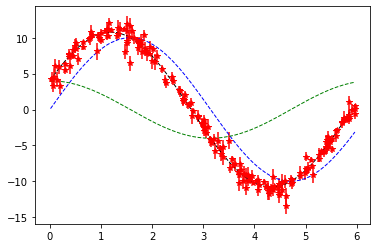

In [88]:
#mu and dt for the images
mu_l=[10.0,4.0,3.5]
dt_l=[0.0,1.57,0.5]
#for simplicity just consider the 1st NI images for now
NI=2;  
fx=np.zeros((NI,len(x)))
for i in np.arange(NI): 
    fx[i]=intrinsic_func(x,mu_l[i],dt_l[i])
    
fx_total=np.sum(fx,axis=0)

y=np.random.normal(fx_total, sigfx)

plt.errorbar(x,y,yerr=sigfx,fmt='r*')
plt.plot(x,fx_total,c='k',lw=1.0,ls="--")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(x,fx[i],c=clr[i],lw=1.0,ls="--")

plt.show()

In [89]:
#with lmfit minimization
p = lmfit.Parameters()

p.add_many(('mu1', 1.0),('mu2', 1.0),('dt1', 1.0),)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi)
#p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

#res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=200,
#                     params=mi.params, is_weighted=False)
#lmfit.report_fit(res.params)

Parameters([('mu1', <Parameter 'mu1', 1.0, bounds=[-inf:inf]>), ('mu2', <Parameter 'mu2', 1.0, bounds=[-inf:inf]>), ('dt1', <Parameter 'dt1', 1.0, bounds=[-inf:inf]>)])
[[Variables]]
    mu1:  10.9546145 +/- 3692652.42 (33708647.76%) (init = 1)
    mu2:  4.00263916 +/- 848631.950 (21201809.98%) (init = 1)
    dt1:  8.08587057 +/- 897861.338 (11104077.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.500)
    C(mu1, dt1) =  1.000
    C(mu1, mu2) =  1.000
    C(mu2, dt1) =  1.000


In [90]:
#with lmfit emcee
%reset_selective -f mi
p = lmfit.Parameters()

p.add_many(('mu1', 8.0, True, 1.0,20.0),('mu2', 4.0,True, 1.0,10.0))
p.add('dt1', value=1.50, min=0.0, max=2.0)
print(p)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
#mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
#lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
#print(mi)
p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1.5, bounds=[0.0:2.0]>)])
Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1.5, bounds=[0.0:2.0]>)])


100%|██████████| 1000/1000 [00:05<00:00, 196.96it/s]

[[Variables]]
    mu1:        9.37962198 +/- 1.51701754 (16.17%) (init = 8)
    mu2:        4.03529280 +/- 0.32000513 (7.93%) (init = 4)
    dt1:        1.40068355 +/- 0.35728212 (25.51%) (init = 1.5)
    __lnsigma:  0.06986848 +/- 0.05173203 (74.04%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt1) =  0.996
    C(mu1, mu2) = -0.791
    C(mu2, dt1) = -0.744


odict_values([9.37962198163856, 4.035292798607792, 1.4006835456577247, 0.06986847669781673])


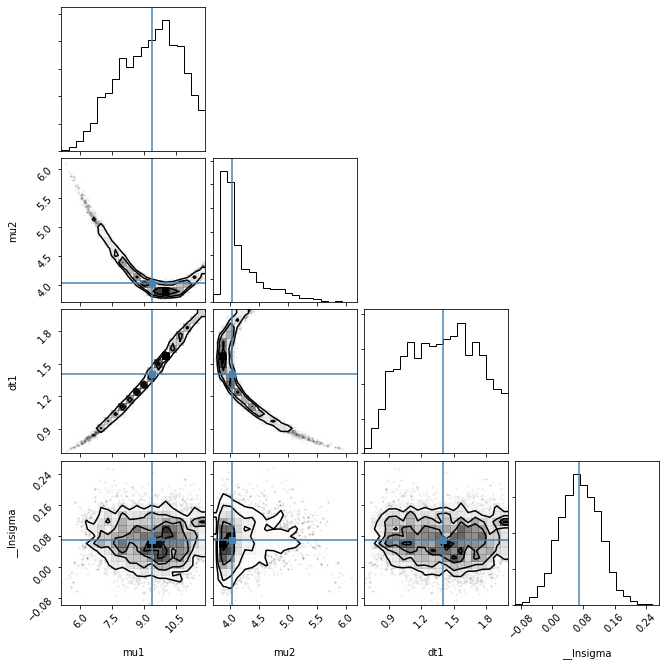

In [99]:
import corner
print(res.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

In [93]:
#using mcmc

def log_likelihood(theta, x, y, yerr): 
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    dp=len(x);
    fxx=np.zeros((NI,dp))
    for i in np.arange(NI):
        fxx[i]=mu[i]*np.sin(x+dt[i])#/np.power(x,pr)
        
    model =np.sum(fxx,axis=0) #mu*np.sin(x)/np.power(x,pr)
    sigma2 = yerr**2;#yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 /sigma2)

def log_prior(theta):
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    if 1.0 < mu[0] < 10.0 and 1.0 < mu[1] < 10.0 and 0 < dt1 <2:# and 0.0 < pr < 2.0:# and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

p0=np.array([8.0,4.0,1.5]);
Npar=len(p0); Nwalker=200
pos = p0 + 1e-4 * np.random.randn(Nwalker, Npar)
nwalkers, ndim = (Nwalker, Npar)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigfx))
xxx1=sampler.run_mcmc(pos,2000);

In [94]:
flat_samples = sampler.get_chain(discard=200, thin=7, flat=True)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.5,16,25, 50,75, 84,97.5])
    print(mcmc)

[1.7993801  4.46924481 5.59538096 7.49857167 8.83483045 9.24384892
 9.88140274]
[3.86832485 3.98108169 4.07742779 4.65010839 5.90102289 6.78598497
 9.11660546]
[0.44179217 0.61135382 0.72026291 0.99369623 1.27271155 1.37035049
 1.53231068]


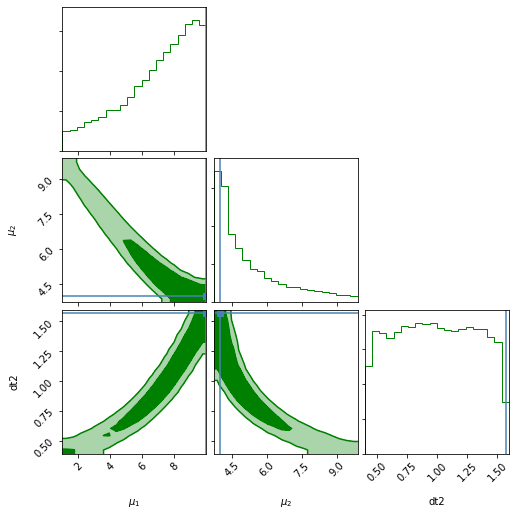

In [95]:
import corner
samples1 = sampler.chain[:, 300:, ].reshape((-1, 3))
fig1 = corner.corner(samples1, labels=[r"$\mu_1$",r"$\mu_2$","dt2"],
                        color='g', smooth=1,
                        levels=(0.68,0.95), plot_density=0, fill_contours=1, plot_datapoints=0, truths=[mu_l[0],mu_l[1], dt_l[1]])

In [96]:
#pystan: assuming the model=mu*sin(t+dt); setting dt1=0;
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=0, upper=2> dt[ni-1];
    //real sig;
    
}
model {
    real dum;
    real dtt;
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            if(j==1){dtt=0;}
            else {dtt=dt[j-1];}
            dum=dum+mu[j]*sin(x[i]+dtt);
        }
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum,yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': len(x),'ni':NI, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52dd2ffaf69b610ba47b7a3827b6c627 NOW.


Inference for Stan model: anon_model_52dd2ffaf69b610ba47b7a3827b6c627.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   7.17    0.14   3.17   1.28   4.54   7.74   9.88  11.59    488   1.01
mu[2]   5.48    0.09   1.84   3.86   4.02   4.51   6.75   9.57    462   1.01
dt[1]   1.09    0.02    0.5   0.42   0.62   1.04   1.53   1.95    548   1.01
lp__  -197.2    0.05   1.34 -200.8 -197.8 -196.9 -196.3 -195.7    725    1.0

Samples were drawn using NUTS at Mon Nov 18 15:32:19 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
#pystan: modelling the intrinsic function with 9 parameters and interpolation
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=0.0, upper=2.0> dt[ni-1];
    vector <lower=-1, upper=1> [NP] P;
    //real sig;
    
}
model {
    real dum;
    vector[NP] tm;
    real td=0.5;
    real dum_t;
    int ti;
    real dtt;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            dum_t=x[i];
            if(j==1){dtt=0;}
            else {dtt=dt[j-1];}
            
            dum_t=dum_t+dtt;
            ti=1;
            //because there is no real to int conversion in stan we have to do it in this way
            while(dum_t>ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);
            dum+=mu[j]*mod_intr_f;
        }
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum, yerror[i]);
    }
}
"""
NP=17;
# Put our data in a dictionary
data = {'N': len(x),'ni':NI,'NP':NP, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1c262001aba6c000f169cb20d4f6059e NOW.
